# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# ID3 Algorithma

## Importing libraries

In [75]:
from collections import Counter
from math import e
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import os
import pickle
from scipy.sparse import csc_matrix, csr_matrix, isspmatrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, ClassifierMixin

## Loading the dataset

In [2]:
# Load test data
test_folder = '../data/test/'
test_files = os.listdir(test_folder)
test_df = pd.merge(pd.read_csv(test_folder + test_files[0]), pd.read_csv(test_folder + test_files[1]), on='id')
for file in test_files[2:]:
    if file == 'UNSW-NB15_features-modified.csv':
        continue
    test_df = pd.merge(test_df, pd.read_csv(test_folder + file), on='id')

# Load train data
train_folder = '../data/train/'
train_files = os.listdir(train_folder)
train_df = pd.merge(pd.read_csv(train_folder + train_files[0]), pd.read_csv(train_folder + train_files[1]), on='id')
for file in train_files[2:]:
    if file == 'UNSW-NB15_features-modified.csv':
        continue
    train_df = pd.merge(train_df, pd.read_csv(train_folder + file), on='id')

### ID3 Implementation

In [100]:
class ID3(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0):
        """Initialize the ID3 decision tree classifier."""
        self.tree = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.ccp_alpha = ccp_alpha

    def entropy(self, labels, base=np.e):
        """
        Compute the entropy of a list of labels.
        :param labels: 
        :param base: 
        :return: 
        """
        labels = np.asarray(labels)
        _, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        return -np.sum(probabilities * np.log(probabilities) / np.log(base))

    def information_gain(self, X, y, feature):
        """
        Compute the information gain of a feature.
        :param X: 
        :param y: 
        :param feature: 
        :return: 
        """
        total_impurity = self.entropy(y)
        if isspmatrix(X):
            feature_series = pd.Series(X[:, feature].toarray().ravel())
        else:
            feature_series = X.iloc[:, feature]
        grouped = y.groupby(feature_series)
        weighted_impurity = sum((len(group) / len(y)) * self.entropy(group) for _, group in grouped)
        return total_impurity - weighted_impurity

    def best_feature_(self, X, y):
        """
        Find the best feature to split on.
        :param X: 
        :param y: 
        :return: 
        """
        features = range(X.shape[1])
        gains = [self.information_gain(X, y, feature) for feature in features]
        if all(gain == 0 for gain in gains):
            return None  # No information gain
        return np.argmax(gains)

    def fit(self, X, y, features=None, depth=0):
        """
        Fit the decision tree classifier.
        :param X: 
        :param y: 
        :param features: 
        :param depth: 
        :return: 
        """
        X, y = self._check_input(X, y)

        if features is None:
            features = list(range(X.shape[1]))

        # Stopping criteria
        if len(np.unique(y)) == 1:
            return {"value": y.iloc[0], "impurity": 0.0, "samples": len(y)}
        if len(features) == 0 or (self.max_depth is not None and depth >= self.max_depth):
            return {"value": y.mode()[0], "impurity": self.entropy(y), "samples": len(y)}
        if len(y) < self.min_samples_split or len(y) <= self.min_samples_leaf:
            return {"value": y.mode()[0], "impurity": self.entropy(y), "samples": len(y)}

        # Find the best feature and split data
        best_feature = self.best_feature_(X, y)
        if best_feature is None:
            return {"value": y.mode()[0], "impurity": self.entropy(y), "samples": len(y)}

        unique_vals = np.unique(X[:, best_feature].toarray() if isspmatrix(X) else X.iloc[:, best_feature])
        tree = {"feature": best_feature, "nodes": {}, "impurity": self.entropy(y), "samples": len(y)}

        def process_val(val):
            if isspmatrix(X):
                mask = (X[:, best_feature].toarray().ravel() == val)
            else:
                mask = (X.iloc[:, best_feature] == val).values
            subset_X = X[mask]
            subset_y = y[mask].reset_index(drop=True)

            if subset_y.empty:
                return val, {"value": None, "impurity": 0.0, "samples": 0}

            new_features = [f for f in features if f != best_feature]
            return val, self.fit(subset_X, subset_y, new_features, depth + 1)

        results = Parallel(n_jobs=-1)(delayed(process_val)(val) for val in unique_vals)

        for val, subtree in results:
            tree["nodes"][val] = subtree

        self.tree = tree
        return tree

    def prune(self, tree=None):
        """
        Prune the decision tree.
        :param tree: 
        :return: 
        """
        if tree is None:
            tree = self.tree

        if "nodes" not in tree or not tree["nodes"]:
            return tree["impurity"], None

        subtree_impurities = []
        subtree_trees = []
        for key, subtree in tree["nodes"].items():
            imp, subpruned = self.prune(subtree)
            subtree_impurities.append(imp)
            subtree_trees.append((key, subpruned))

        subtree_cost = sum(subtree_impurities) + self.ccp_alpha * len(tree["nodes"])
        if subtree_cost < tree["impurity"] + self.ccp_alpha:
            tree = {"value": max(Counter(
                [subtree["value"] for subtree in tree["nodes"].values() if "value" in subtree]).items(),
                                 key=lambda x: x[1])[0]}
        else:
            for key, subpruned in subtree_trees:
                if subpruned:
                    tree["nodes"][key] = subpruned

        return tree["impurity"], tree

    def predict_one(self, x, tree):
        """Predict a single data point."""
        if "value" in tree:
            return tree["value"]
        feature = tree["feature"]
        if x[feature] in tree["nodes"]:
            return self.predict_one(x, tree["nodes"][x[feature]])
        else:
            leaf_values = [subtree["value"] for subtree in tree["nodes"].values() if "value" in subtree]
            if leaf_values:
                return max(Counter(leaf_values).items(), key=lambda x: x[1])[0]
            return tree.get("value", None)

    def predict(self, X):
        """Predict multiple data points."""
        X = self._check_input(X)
        return np.array([self.predict_one(row, self.tree) for row in X.values])

    def _check_input(self, X, y=None):
        """Helper function to check and preprocess inputs."""
        if isspmatrix(X):
            X = csc_matrix(X)
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)
        return X, y

    def save_tree(self, filepath):
        """Save the trained decision tree to a file."""
        with open(filepath, 'wb') as f:
            pickle.dump(self.tree, f)

    def load_tree(self, filepath):
        """Load a decision tree from a file."""
        with open(filepath, 'rb') as f:
            self.tree = pickle.load(f)

    def evaluate(self, X, y):
        """Evaluate the model."""
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        classification_rep = classification_report(y, y_pred)
        f1_macro = f1_score(y, y_pred, average='macro')
        print(f'F1-Score Macro Average: {f1_macro}')
        print(f'Accuracy: {accuracy}')
        print(f'Classification Report:\n{classification_rep}')

    def submission(self, X, test_id=None):
        """Create a submission file."""
        y_pred = self.predict(X)
        submission = pd.DataFrame(y_pred, columns=['attack_cat'])
        if test_id is not None:
            submission.insert(0, "id", test_id)
        submission.to_csv('ID3-Save/submission_id3.csv', index=False)
        print("Submission file saved as 'submission_id3.csv'")

### Evaluate the model against Scikit-learn's DecisionTreeClassifier

In [93]:
# 1. Data Preparation
X = train_df.drop(columns=['attack_cat', 'id', 'label'], axis=1)
y = train_df['attack_cat']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Setup custom preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, random_state=42)

In [ ]:
# 2. Pipeline
if not os.path.exists('decision_tree.pkl'):
    id3_model = ID3(min_samples_split=10, min_samples_leaf=5, ccp_alpha=0.01, max_depth=10)
    pipeline_id3 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', id3_model)
    ])
    pipeline_id3.fit(X_train, y_train)

else:
    id3_model = ID3()
    id3_model.load_tree('decision_tree.pkl')
    pipeline_id3 = Pipeline(steps=[
        ('classifier', id3_model)
    ])

In [79]:
# 4. Access the classifier step
# Save the trained tree
id3_classifier = pipeline_id3.named_steps['classifier']
id3_classifier.save_tree("ID3-Save/decision_tree.pkl")
print("Tree saved successfully.")

Tree saved successfully.


In [80]:
# 5. Prune the tree to avoid overfitting (optional)
id3_classifier.prune()
print("Tree pruned successfully.")

Tree pruned successfully.


In [81]:
    # 6. Evaluate the model
print('Custom ID3')
y_pred_custom = pipeline_id3.predict(X_val)

Custom ID3


In [82]:
accuracy = accuracy_score(y_val, y_pred_custom)
classification_rep = classification_report(y_val, y_pred_custom)
f1_macro = f1_score(y_val, y_pred_custom, average='macro')
print(f'F1-Score Macro Average: {f1_macro}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

F1-Score Macro Average: 0.355953452218142
Accuracy: 0.6572569147419447
Classification Report:
                precision    recall  f1-score   support

      Analysis       1.00      0.16      0.27        38
      Backdoor       0.00      0.00      0.00        37
           DoS       0.26      0.07      0.11       246
      Exploits       0.48      0.39      0.43       671
       Fuzzers       0.76      0.25      0.37       379
       Generic       0.96      0.98      0.97       790
        Normal       0.58      0.97      0.72      1099
Reconnaissance       0.90      0.36      0.51       216
     Shellcode       0.38      0.11      0.17        27
         Worms       0.00      0.00      0.00         4

      accuracy                           0.66      3507
     macro avg       0.53      0.33      0.36      3507
  weighted avg       0.66      0.66      0.61      3507



C:\Users\mfauz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mfauz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mfauz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


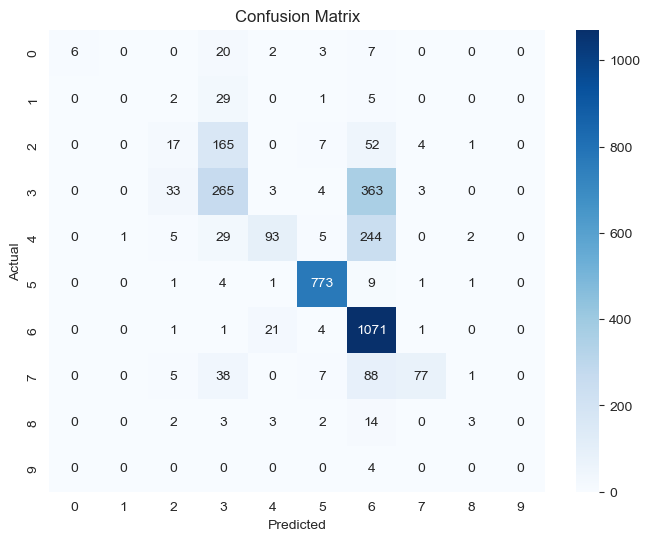

In [83]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
test_id = test_df['id']
X_test = test_df.drop(columns=['id'])

# Predict probabilities on the test set
y_test = pipeline_id3.predict(X_test)

# Create DataFrame for submission
submission = pd.DataFrame(y_test, columns=['attack_cat'])
submission.insert(0, "id", test_id)

# Save results to CSV
submission.to_csv('ID3-Save/submission_id3.csv', index=False)
print("Submission file saved as 'submission_id3.csv'")

Submission file saved as 'submission_logistic_regression.csv'


In [85]:
# Scikit-learn DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
pipeline_scikit = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline_scikit.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src...
       'trans_depth', 'response_body_len', 'sjit', 'djit', 'sinpkt', 'dinpkt',
       'tcprtt', 'synack', 'ackdat'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['state', 'service', 'proto'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [86]:
# Evaluate the model
print('Scikit-learn DecisionTreeClassifier')
y_pred_scikit = pipeline_scikit.predict(X_val)

Scikit-learn DecisionTreeClassifier


In [87]:
accuracy = accuracy_score(y_val, y_pred_scikit)
classification_rep = classification_report(y_val, y_pred_scikit)
f1_macro = f1_score(y_val, y_pred_scikit, average='macro')
print(f'F1-Score Macro Average: {f1_macro}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

F1-Score Macro Average: 0.6072299491381659
Accuracy: 0.7966923296264614
Classification Report:
                precision    recall  f1-score   support

      Analysis       0.21      0.16      0.18        38
      Backdoor       0.12      0.08      0.10        37
           DoS       0.33      0.33      0.33       246
      Exploits       0.66      0.72      0.69       671
       Fuzzers       0.73      0.65      0.69       379
       Generic       0.98      0.99      0.98       790
        Normal       0.91      0.93      0.92      1099
Reconnaissance       0.82      0.74      0.78       216
     Shellcode       0.56      0.56      0.56        27
         Worms       1.00      0.75      0.86         4

      accuracy                           0.80      3507
     macro avg       0.63      0.59      0.61      3507
  weighted avg       0.79      0.80      0.79      3507



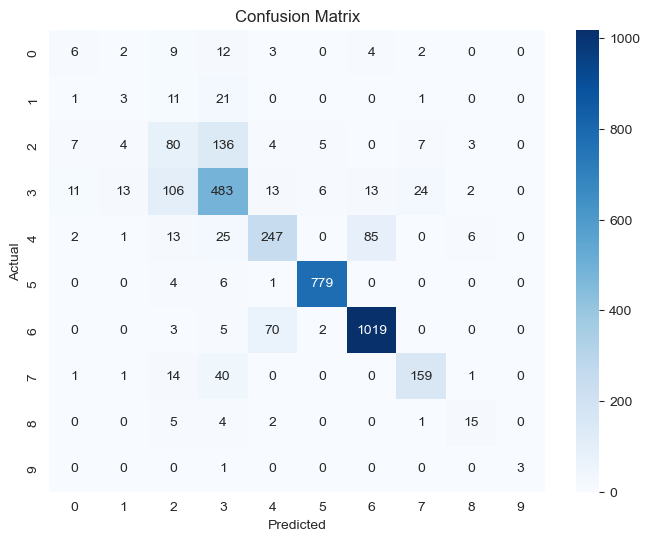

In [88]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_scikit)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Comparison

In [89]:
# Compare the two models
print('Custom ID3')
accuracy = accuracy_score(y_val, y_pred_custom)
f1_macro = f1_score(y_val, y_pred_custom, average='macro')
print(f'F1-Score Macro Average: {f1_macro}')
print(f'Accuracy: {accuracy}')

print('Scikit-learn DecisionTreeClassifier')
accuracy = accuracy_score(y_val, y_pred_scikit)
f1_macro = f1_score(y_val, y_pred_scikit, average='macro')
print(f'F1-Score Macro Average: {f1_macro}')
print(f'Accuracy: {accuracy}')

Custom ID3
F1-Score Macro Average: 0.355953452218142
Accuracy: 0.6572569147419447
Scikit-learn DecisionTreeClassifier
F1-Score Macro Average: 0.6072299491381659
Accuracy: 0.7966923296264614
